In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")
!pip3 install scipy
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
import uproot,glob


plt.rcParams["figure.figsize"] = (10, 8)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.6/29.6 MB 11.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [6]:
from scipy.optimize import curve_fit

def gauss(x, A,mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

def res_plot(a, fnc=gauss, bins=None, label=None, unit=" mm", legend=True, eb_args={}, fitcurve_args={}, nsigma=3):
    a=np.array(a)
    mean=np.mean(a)
    sigma=np.std(a)
    if bins is None :
        bins = np.linspace(mean-3*sigma,mean+3*sigma, 20)
    h,x=np.histogram(a, bins=bins)
    bc=(x[1:]+x[:-1])/2
    eb=plt.errorbar(bc, h, np.sqrt(h), ls='', label=label,**eb_args)
    curve=None
    a_in_window=a[(a>=x[0])&(a<=x[-1])]
    p0=[10,0, np.std(a_in_window)*.9]
    slc=np.abs(bc-np.mean(a_in_window))<nsigma*np.std(a_in_window)
    try:
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))
        print(f"fit: $\\sigma={coeff[2]:.1f}\\pm{np.sqrt(var_matrix[2][2]):.1f}${unit}")
        x=np.linspace(x[0], x[-1], 100)
        
        digits=1 if np.sqrt(var_matrix[2][2])>0.1 else 2
        if coeff[2]< 1000 and var_matrix[2][2]<1000:
            curve=plt.plot(x, fnc(x,*coeff), label=f"fit: $\\sigma={abs(coeff[2]):.{digits}f}\\pm {np.sqrt(var_matrix[2][2]):.{digits}f}${unit}",
                          **fitcurve_args)
        if legend:
            plt.legend(loc='upper left', fontsize=20)
        return coeff[2],np.sqrt(var_matrix[2][2]), eb, curve
    except:
        return 0, 0, eb, None
    

In [7]:
#do just the calculation of the resolution
def res_calc(a, fnc=gauss, bins=None, nsigma=2):
    a=np.array(a)
    mean=np.mean(a)
    sigma=np.std(a)
    if bins is None :
        bins = np.linspace(mean-3*sigma,mean+3*sigma, 20)
    h,x=np.histogram(a, bins=bins)
    bc=(x[1:]+x[:-1])/2
    a_in_window=a[(a>=x[0])&(a<=x[-1])]
    p0=[10,0, np.std(a_in_window)*.9]
    slc=np.abs(bc-np.mean(a_in_window))<nsigma*np.std(a_in_window)
    try:
        coeff, var_matrix = curve_fit(fnc, bc[slc], h[slc], p0=p0,
                                 sigma=np.sqrt(h[slc]))
        return abs(coeff[2]),np.sqrt(var_matrix[2][2])
    except:
        return 0, 0

In [8]:
def w0_scan(df, req_field, bins, min_w0=3, max_w0=8):
    best_field=None
    best_s=100000
    for field in df.columns:
        #print(field)
        if req_field+"_w0" in field and len(df[field])>0 :
            if type(list(df[field])[0]) !=float: continue
            #print(type(df[field][0]))
            
            w0=float(field.split("_")[-1].replace("pt", "."))
            if  w0<min_w0 or w0>max_w0:
                continue
            
            s,ds= res_calc(df[field], bins=bins)
            if abs(s)<best_s and s!=0 and  s>0.3: #include sanity check
                #print(s)
                best_field=field
                best_s=abs(s)
    return best_field

In [ ]:
arg_w0=dict(min_w0=4.0, max_w0=8)
def plots_1d(Ebeam, bins=np.linspace(-80, 80, 25), particle="neutron", nsigma=2,tag="", w0s=None):
    res_all,dres_all={},{}
    field_nrw="dr"
    field_rw="dr_rw"
    fig,axs=plt.subplots(1,3, figsize=(20,7.5))
    q="abs(x_truth_w0_4pt0)<2500 and abs(y_truth_w0_4pt0)<2500"
    plt.sca(axs[0])
    plt.title("unstaggered hexagons")
    
    path=f'dd4hep/with_cuts/zdc_unstaggered_inf{tag}_reco_{particle}_{Ebeam}GeV_theta_deg.edm4hep.root.csv'
    df = pd.read_csv(path)
    #print(df.columns)
    df =df.query(q)
    
    field=w0_scan(df, field_nrw, bins, **arg_w0) if w0s == None else field_nrw+f"_w0_{w0s['H1']}".replace(".", "pt")
    #w0 = w0_params["H1"][0]+np.log(Ebeam)*w0_params["H1"][1] if particle =="neutron" else \
    #    w0_params_photon["H1"][0]+np.log(Ebeam)*w0_params_photon["H1"][1]
    #w0=np.round(w0*4)/4
    #field=field_nrw+f"_w0_{w0}".replace(".", "pt")
    print(field)
    #print(best_field)
    res,dres, eb, curve= res_plot(df[field], bins=bins, 
                                  label=None,eb_args=dict(color='tab:blue', fillstyle='none', marker='H'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'),nsigma=nsigma)
    res_all["H1"]=res
    dres_all["H1"]=dres
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")


    plt.sca(axs[1])
    plt.title("H3 staggering")
    path=f'dd4hep/with_cuts/zdc_staggered_h3_inf{tag}_reco_{particle}_{Ebeam}GeV_theta_deg.edm4hep.root.csv'
    df = pd.read_csv(path)
    #print(df.columns)
    df=df.query(q)
    field=w0_scan(df, field_nrw, bins, **arg_w0) if w0s == None else field_nrw+f"_w0_{w0s['H3_base']}".replace(".", "pt")
    
    #w0 = w0_params["H3_nrw"][0]+np.log(Ebeam)*w0_params["H3_nrw"][1] if particle =="neutron" else \
    #    w0_params_photon["H3_nrw"][0]+np.log(Ebeam)*w0_params_photon["H3_nrw"][1]
    #w0=np.round(w0*4)/4
    #field=field_nrw+f"_w0_{w0}".replace(".", "pt")
    
    print(field)
    res,dres, eb1, curve1= res_plot(df[field], bins=bins, 
                                  label="baseline", legend=False,eb_args=dict(color='tab:blue', fillstyle='none', marker='H'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'),nsigma=nsigma)
    res_all["H3_baseline"]=res
    dres_all["H3_baseline"]=dres
    
    field=w0_scan(df, field_rw, bins, **arg_w0) if w0s == None else field_rw+f"_w0_{w0s['H3_hex']}".replace(".", "pt")
    #w0 = w0_params["H3_rw"][0]+np.log(Ebeam)*w0_params["H3_rw"][1] if particle =="neutron" else \
    #    w0_params_photon["H3_rw"][0]+np.log(Ebeam)*w0_params_photon["H3_rw"][1]
    #w0=np.round(w0*4)/4
    #field=field_rw+f"_w0_{w0}".replace(".", "pt")
    print(field)
    res,dres, eb2, curve2= res_plot(df[field], bins=bins, 
                                  label="HEXPLIT", legend=False, eb_args=dict(color='tab:orange', fillstyle='full', marker='H'),
                                   fitcurve_args=dict(color='tab:orange', linestyle='-'),nsigma=nsigma)
    res_all["H3_hexplit"]=res
    dres_all["H3_hexplit"]=dres
    if curve2 is not None:
        plt.legend(handles=[eb1, curve1[0], eb2, curve2[0]], loc='upper left')
    else :
        plt.legend(handles=[eb1, curve1[0], eb2], loc='upper left')
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
    
    plt.sca(axs[2])
    plt.title("H4 staggering")
    
    path=f'dd4hep/with_cuts/zdc_staggered_h4_inf{tag}_reco_{particle}_{Ebeam}GeV_theta_deg.edm4hep.root.csv'
    df = pd.read_csv(path).query(q)
    field=w0_scan(df, field_nrw, bins,**arg_w0) if w0s == None else field_nrw+f"_w0_{w0s['H4_base']}".replace(".", "pt")
    #w0 = w0_params["H4_nrw"][0]+np.log(Ebeam)*w0_params["H4_nrw"][1] if particle =="neutron" else \
    #    w0_params_photon["H4_nrw"][0]+np.log(Ebeam)*w0_params_photon["H4_nrw"][1]
    #w0=np.round(w0*4)/4
    #field=field_nrw+f"_w0_{w0}".replace(".", "pt")
    print(field)
    res,dres, eb1, curve1= res_plot(df[field], bins=bins, 
                                  label="baseline", legend=False,eb_args=dict(color='tab:blue', fillstyle='none', marker='H'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'),nsigma=nsigma)
    res_all["H4_baseline"]=res
    dres_all["H4_baseline"]=dres
    field=w0_scan(df, field_rw,bins, **arg_w0) if w0s == None else field_rw+f"_w0_{w0s['H4_hex']}".replace(".", "pt")
    #w0 = w0_params["H4_rw"][0]+np.log(Ebeam)*w0_params["H4_rw"][1] if particle =="neutron" else \
    #    w0_params_photon["H4_rw"][0]+np.log(Ebeam)*w0_params_photon["H4_rw"][1]
    #w0=np.round(w0*4)/4
    #field=field_rw+f"_w0_{w0}".replace(".", "pt")
    print(field)
    res,dres, eb2, curve2= res_plot(df[field], bins=bins, 
                                  label="HEXPLIT", legend=False, eb_args=dict(color='tab:orange', fillstyle='full', marker='H'),
                                   fitcurve_args=dict(color='tab:orange', linestyle='-'),nsigma=nsigma)
    res_all["H4_hexplit"]=res
    dres_all["H4_hexplit"]=dres
    if curve2 is not None:
        plt.legend(handles=[eb1, curve1[0], eb2, curve2[0]], loc='upper left')
    else :
        plt.legend(handles=[eb1, eb2], loc='upper left')
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
    
    axs[0].text(0.1, 0.75, f"simulated {Ebeam} GeV {particle}s", transform=axs[0].transAxes)

    for ax in axs:
        ax.set_ylabel("events")
        ax.set_ylim(0, ax.get_ylim()[1]*1.35)


    plt.tight_layout()
    #plt.savefig(f"images/zdc_results_1d_{Ebeam}_GeV_{particle}.pdf")
    plt.show()
    return res_all,dres_all 

dr_w0_7pt0
fit: $\sigma=2.5\pm0.1$ mm
dr_w0_6pt25
fit: $\sigma=1.8\pm0.1$ mm
dr_rw_w0_8pt0
fit: $\sigma=1.8\pm0.1$ mm
dr_w0_5pt25
fit: $\sigma=1.2\pm0.0$ mm
dr_rw_w0_5pt5
fit: $\sigma=1.4\pm0.0$ mm


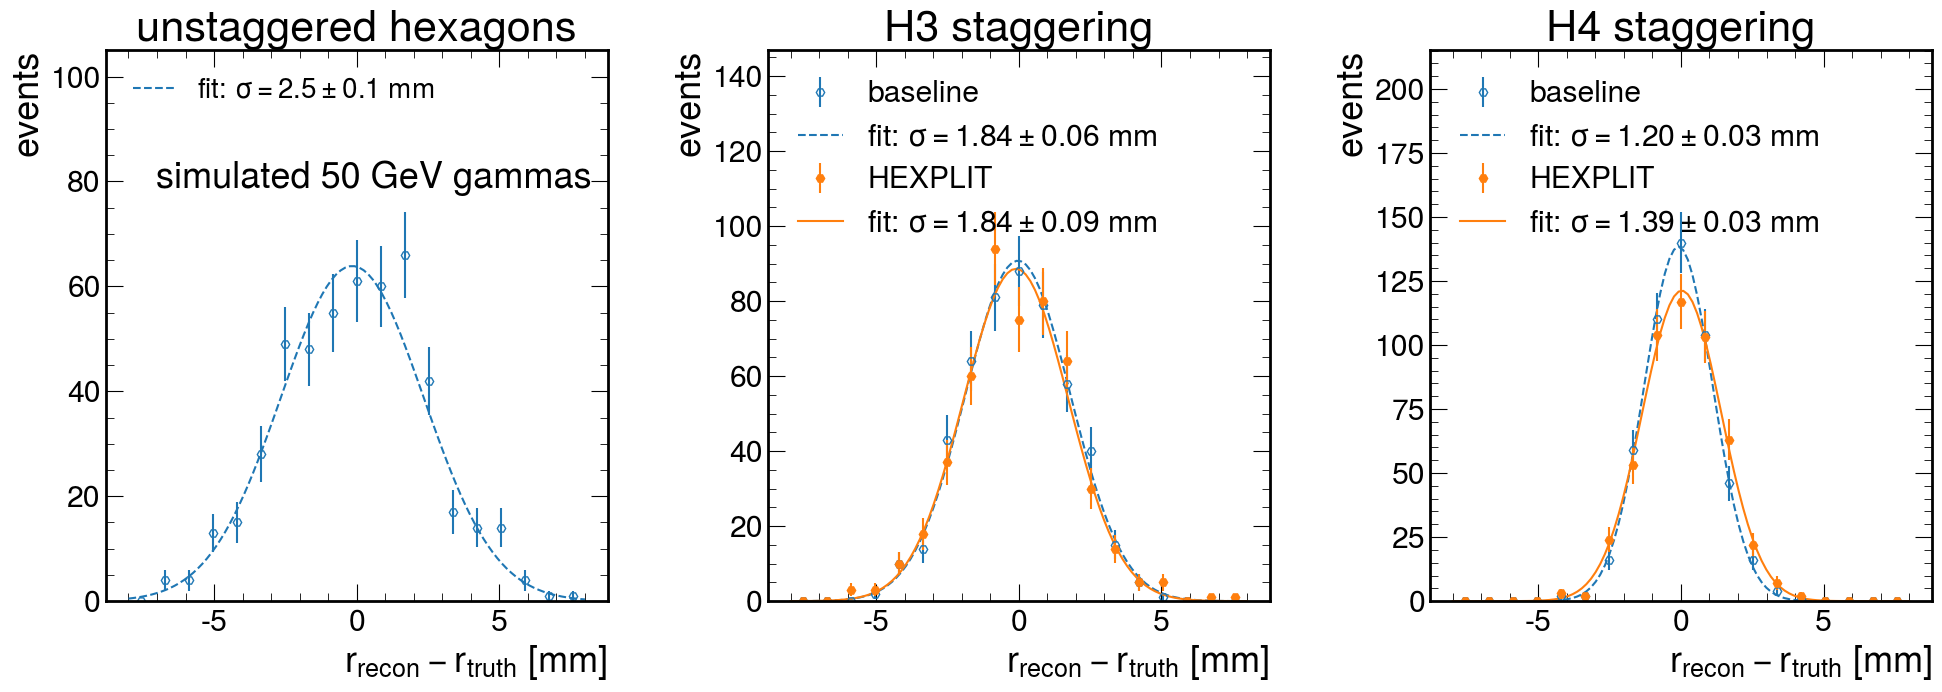

dr_w0_6pt0
fit: $\sigma=9.6\pm0.4$ mm
dr_w0_5pt75
fit: $\sigma=9.7\pm0.7$ mm
dr_rw_w0_5pt5
fit: $\sigma=-6.1\pm0.3$ mm
dr_w0_4pt5
fit: $\sigma=8.2\pm0.9$ mm
dr_rw_w0_4pt75
fit: $\sigma=-4.7\pm0.5$ mm


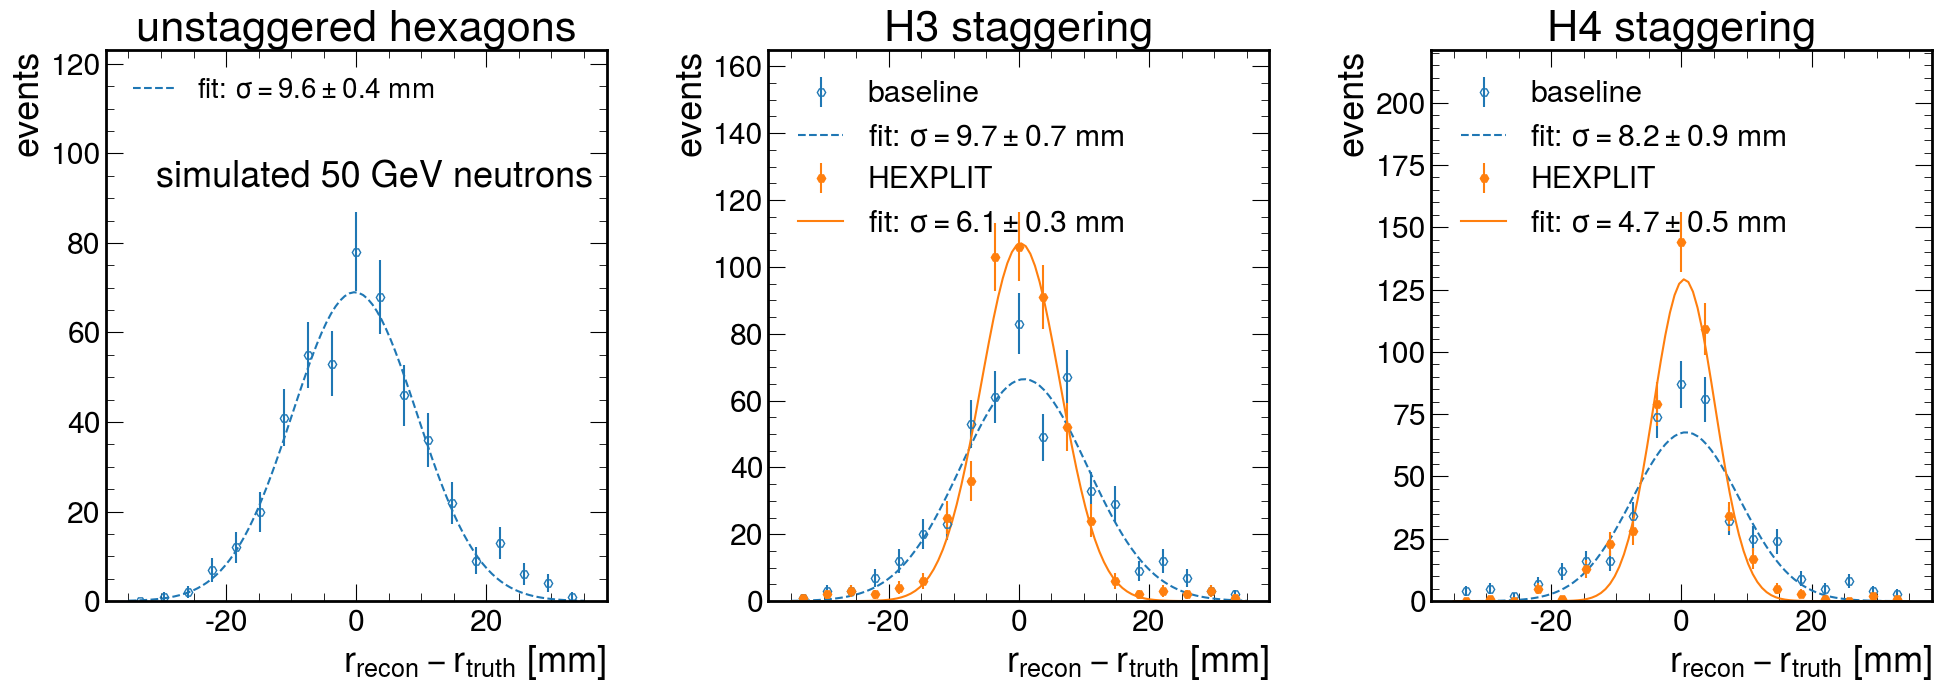

dr_w0_6pt25
fit: $\sigma=1.2\pm0.1$ mm
dr_w0_5pt5
fit: $\sigma=0.8\pm0.0$ mm
dr_rw_w0_6pt75
fit: $\sigma=0.8\pm0.0$ mm
dr_w0_4pt75
fit: $\sigma=0.6\pm0.0$ mm
dr_rw_w0_5pt25
fit: $\sigma=0.6\pm0.1$ mm


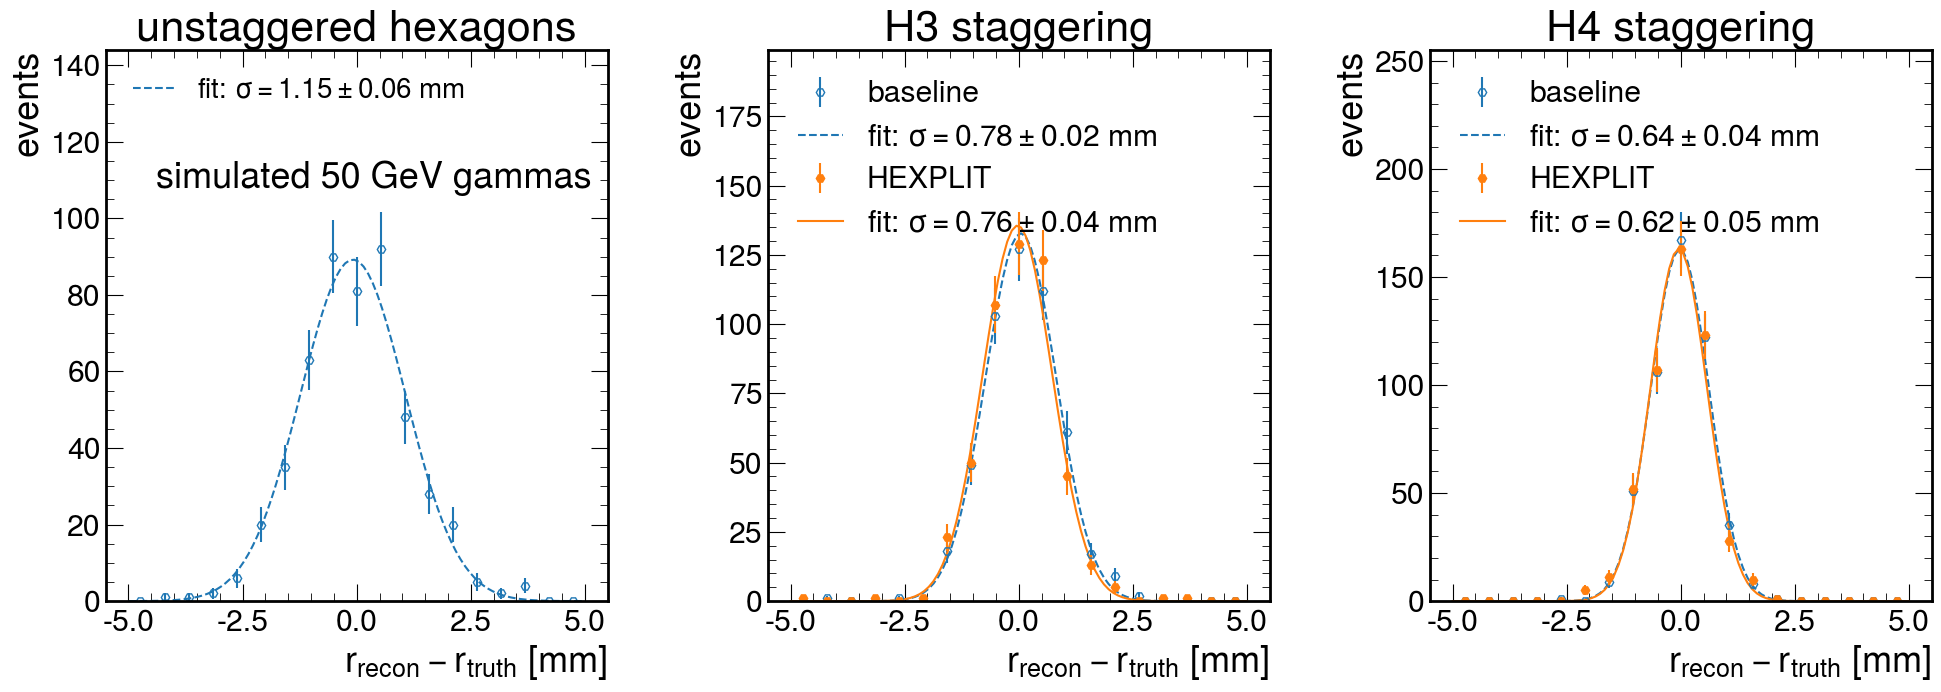

dr_w0_4pt0
fit: $\sigma=7.3\pm0.4$ mm
dr_w0_4pt0
fit: $\sigma=5.5\pm0.4$ mm
dr_rw_w0_4pt75
fit: $\sigma=4.4\pm0.2$ mm
dr_w0_4pt25
fit: $\sigma=5.7\pm0.6$ mm
dr_rw_w0_4pt5
fit: $\sigma=4.1\pm0.3$ mm


/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:931: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/opt/homebrew/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


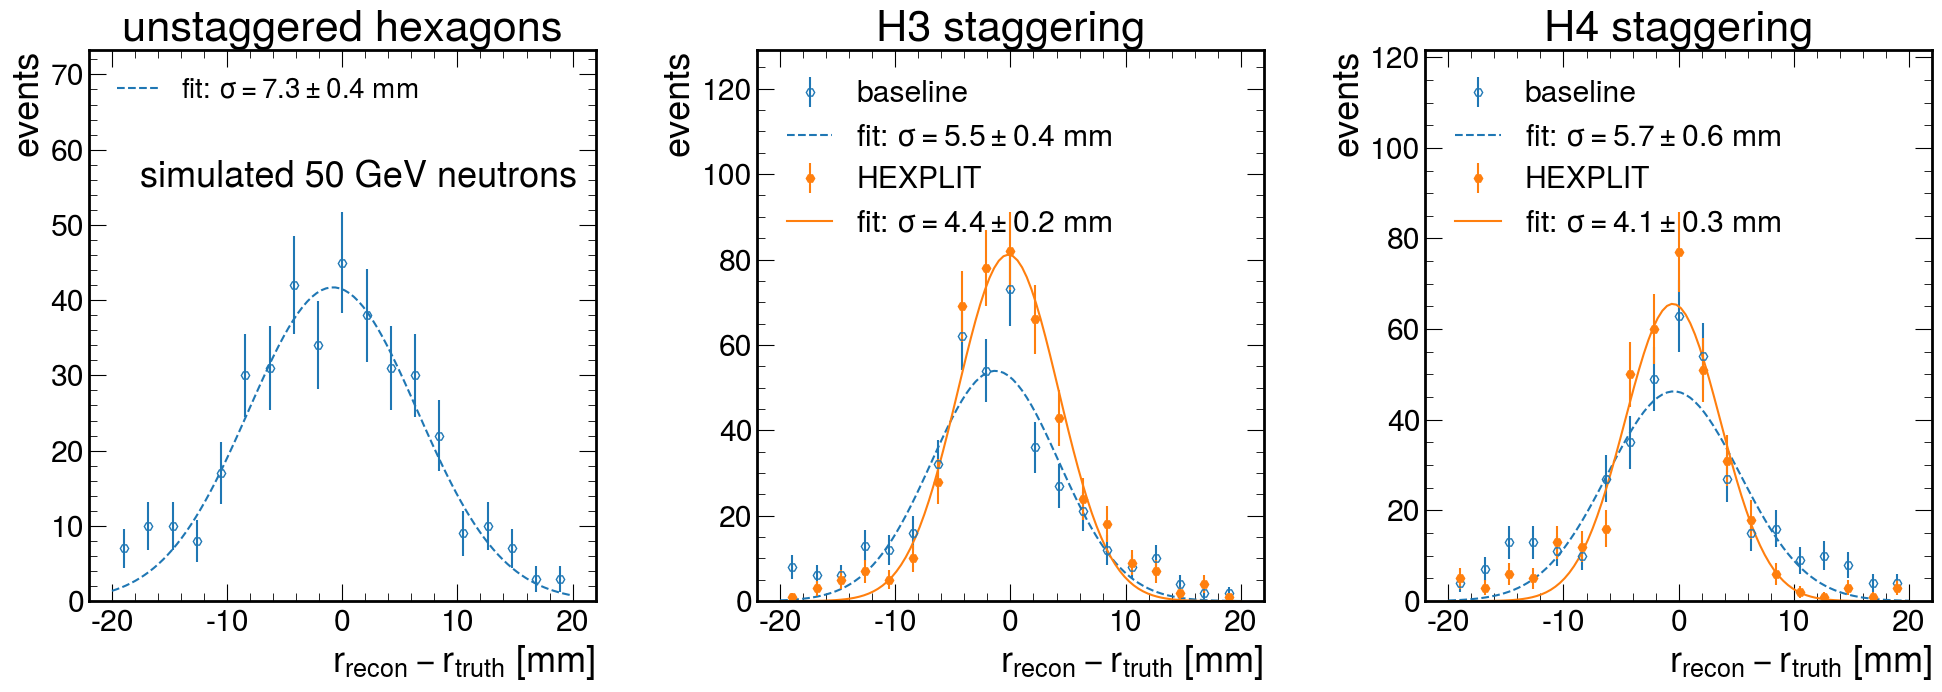

dr_w0_8pt0
fit: $\sigma=-6.3\pm0.6$ mm
dr_w0_7pt75
fit: $\sigma=3.7\pm0.1$ mm
dr_rw_w0_8pt0
fit: $\sigma=-5.0\pm0.5$ mm
dr_w0_6pt25
fit: $\sigma=2.3\pm0.1$ mm
dr_rw_w0_8pt0
fit: $\sigma=2.5\pm0.1$ mm


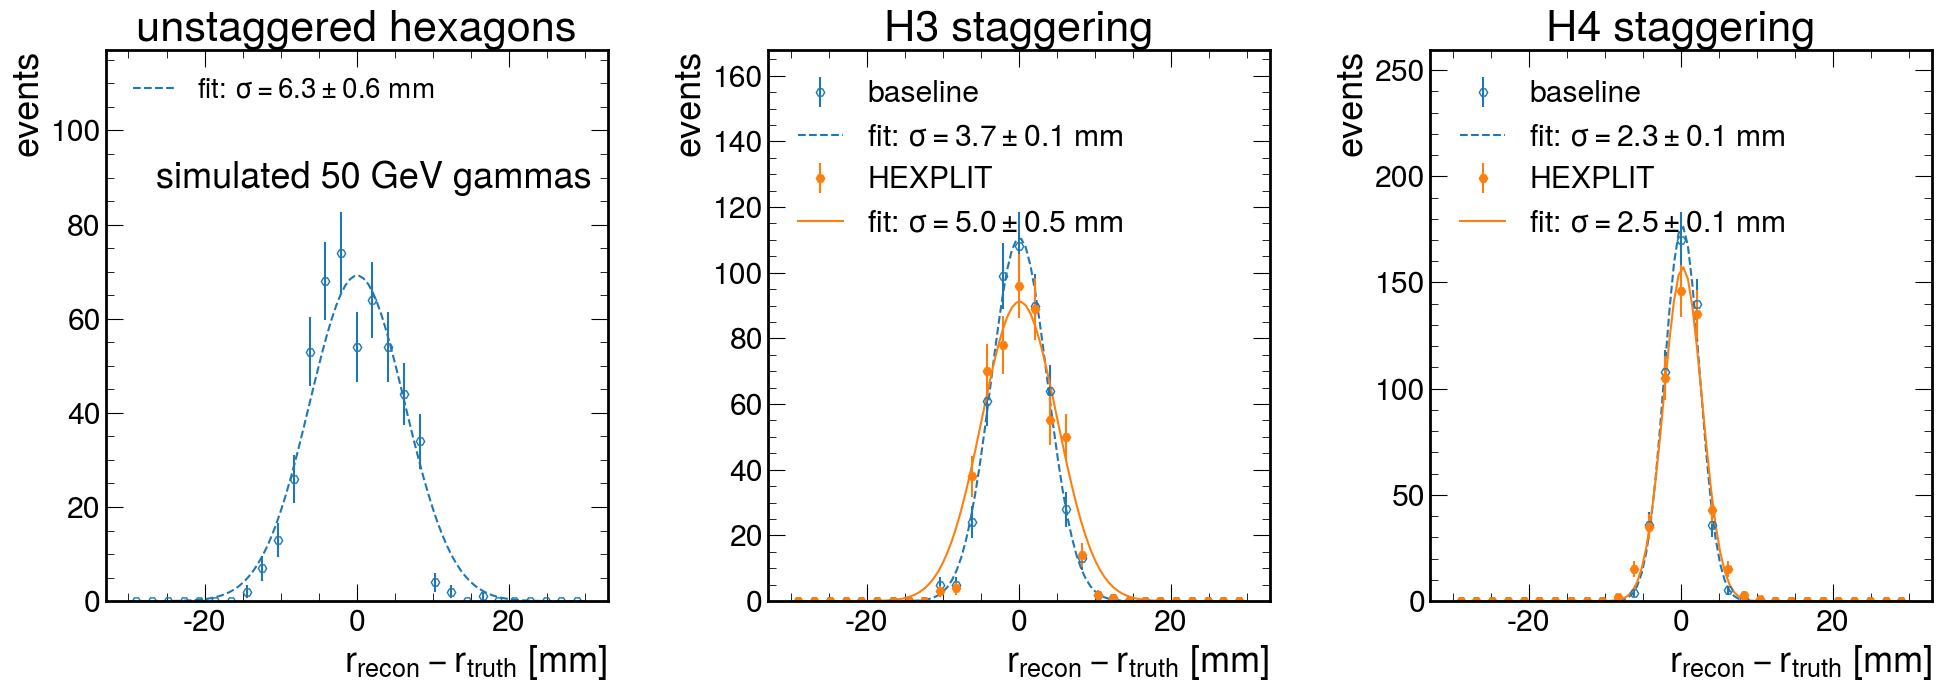

dr_w0_6pt5
fit: $\sigma=12.5\pm1.0$ mm
dr_w0_4pt75
fit: $\sigma=9.9\pm0.4$ mm
dr_rw_w0_6pt0
fit: $\sigma=8.2\pm0.7$ mm
dr_w0_4pt5
fit: $\sigma=8.7\pm0.6$ mm
dr_rw_w0_5pt0
fit: $\sigma=6.1\pm0.1$ mm


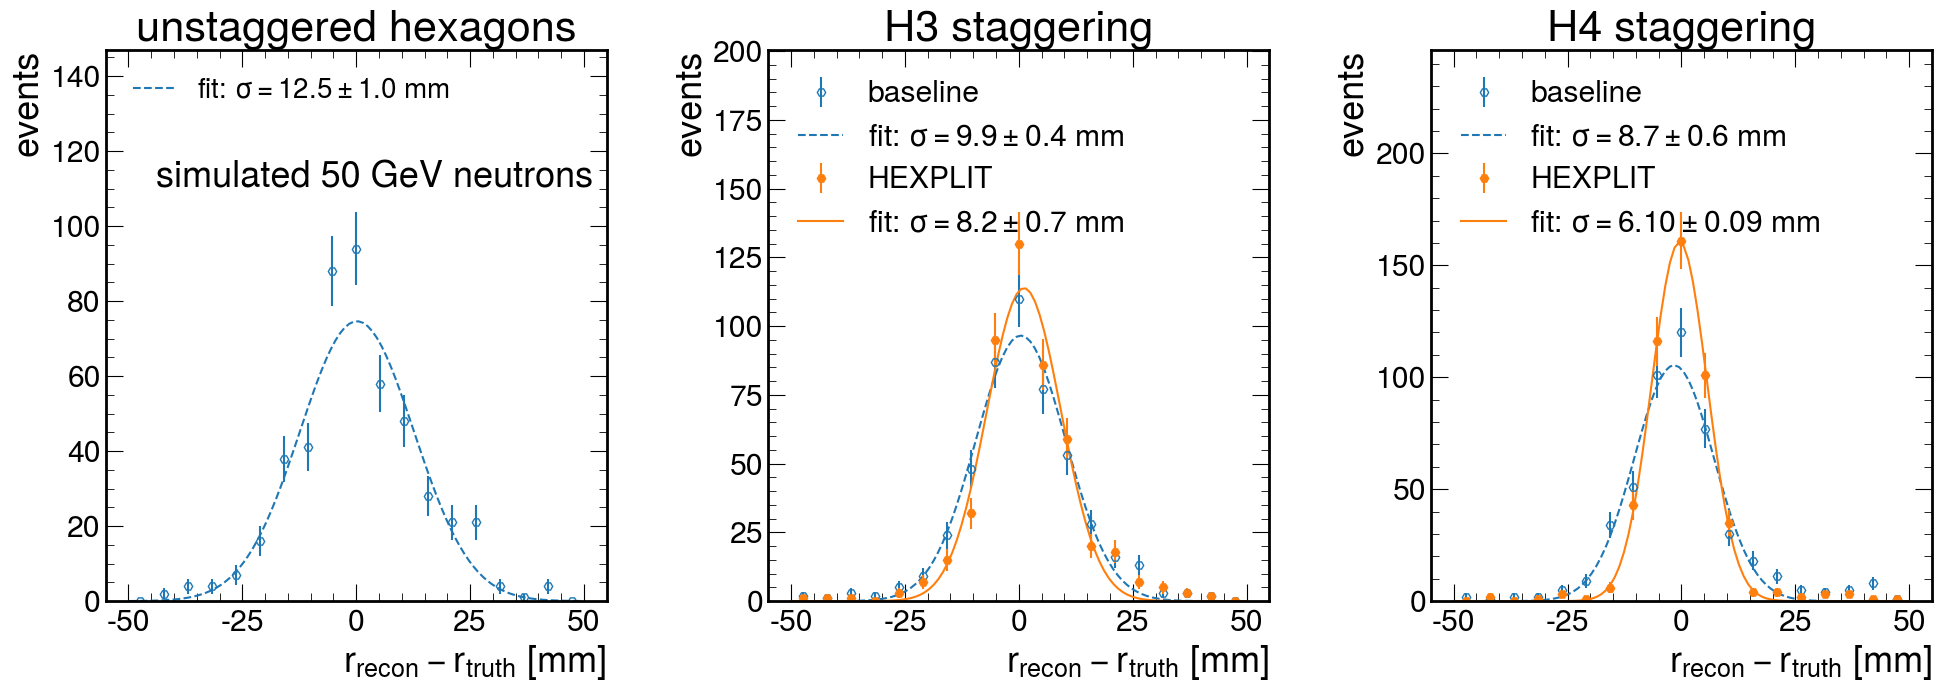

In [115]:
#plots_1d(10) 
res_all, dres_all={},{}
sizes={"normal":31.3, "small":31.3/2, "large":31.3*2}
res_all[("gamma","normal")], dres_all[("gamma","normal")] = plots_1d(50, bins=np.linspace(-8,8, 20), particle="gamma", nsigma=2,tag="") 
res_all[("neutron","normal")], dres_all[("neutron","normal")] = plots_1d(50, bins=np.linspace(-35,35, 20), 
                            particle="neutron", nsigma=2,tag="", w0s=dict(H1=6.0, H3_base=5.75,H3_hex=5.5, H4_base=4.5, H4_hex=4.75))

res_all[("gamma","small")], dres_all[("gamma","small")] = plots_1d(50, bins=np.linspace(-5,5, 20), particle="gamma", nsigma=2, tag="_smallcells") 
res_all[("neutron","small")], dres_all[("neutron","small")] = plots_1d(50, bins=np.linspace(-20,20, 20), particle="neutron", nsigma=2,tag="_smallcells") 

res_all[("gamma","large")], dres_all[("gamma","large")] = plots_1d(50, bins=np.linspace(-30,30, 30), particle="gamma", nsigma=2, tag="_largecells") 
res_all[("neutron","large")], dres_all[("neutron","large")] = plots_1d(50, bins=np.linspace(-50,50, 20), particle="neutron", nsigma=2,tag="_largecells") 

#plots_1d(100, bins=np.linspace(-30,30, 20)) 
#plots_1d(20, bins=np.linspace(-40,40, 20)) 
#plots_1d(100, bins=np.linspace(-50,50, 25)) 

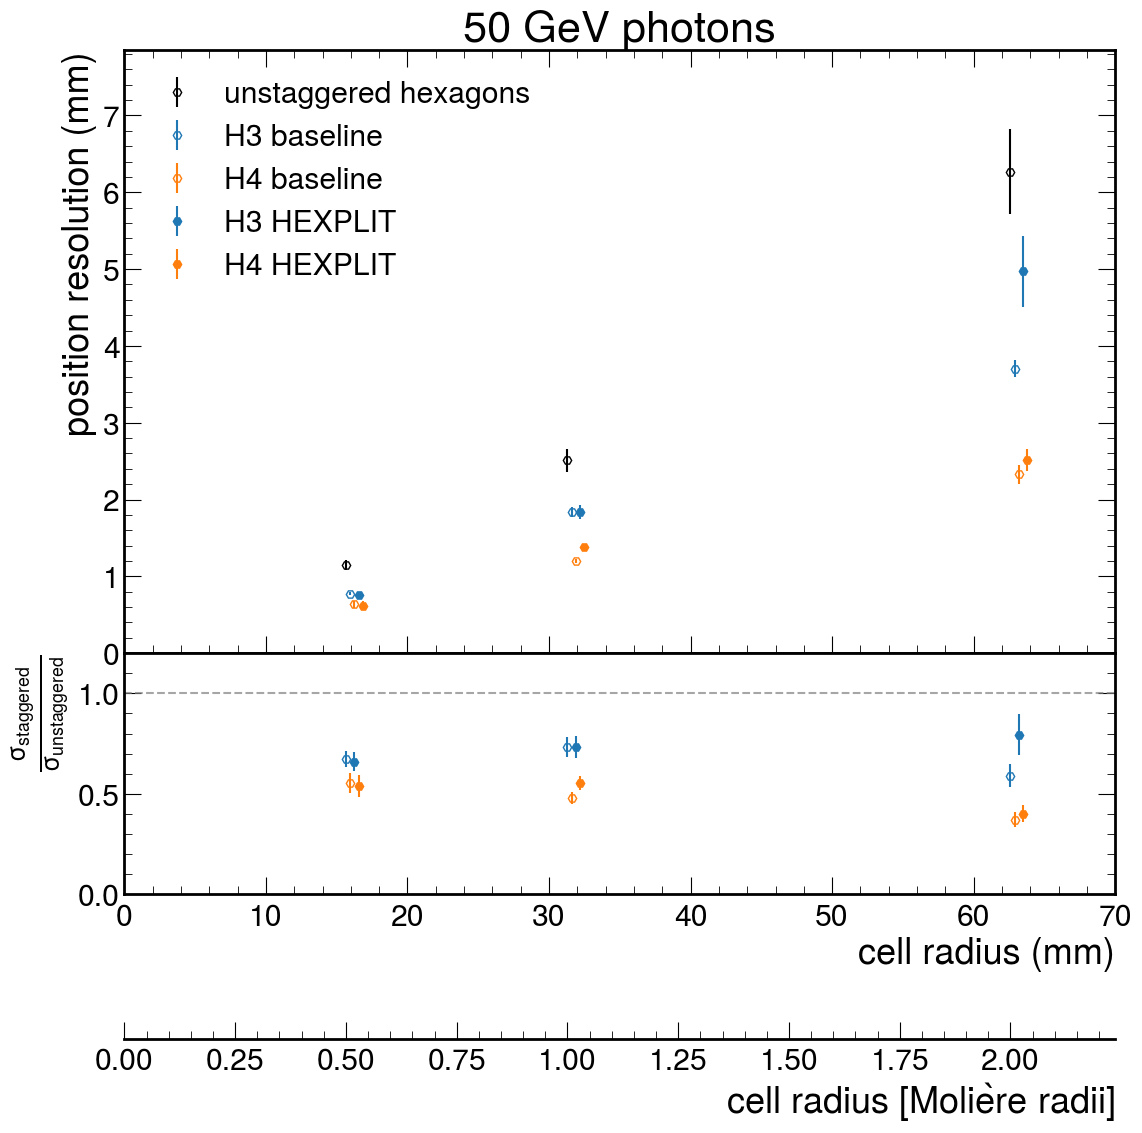

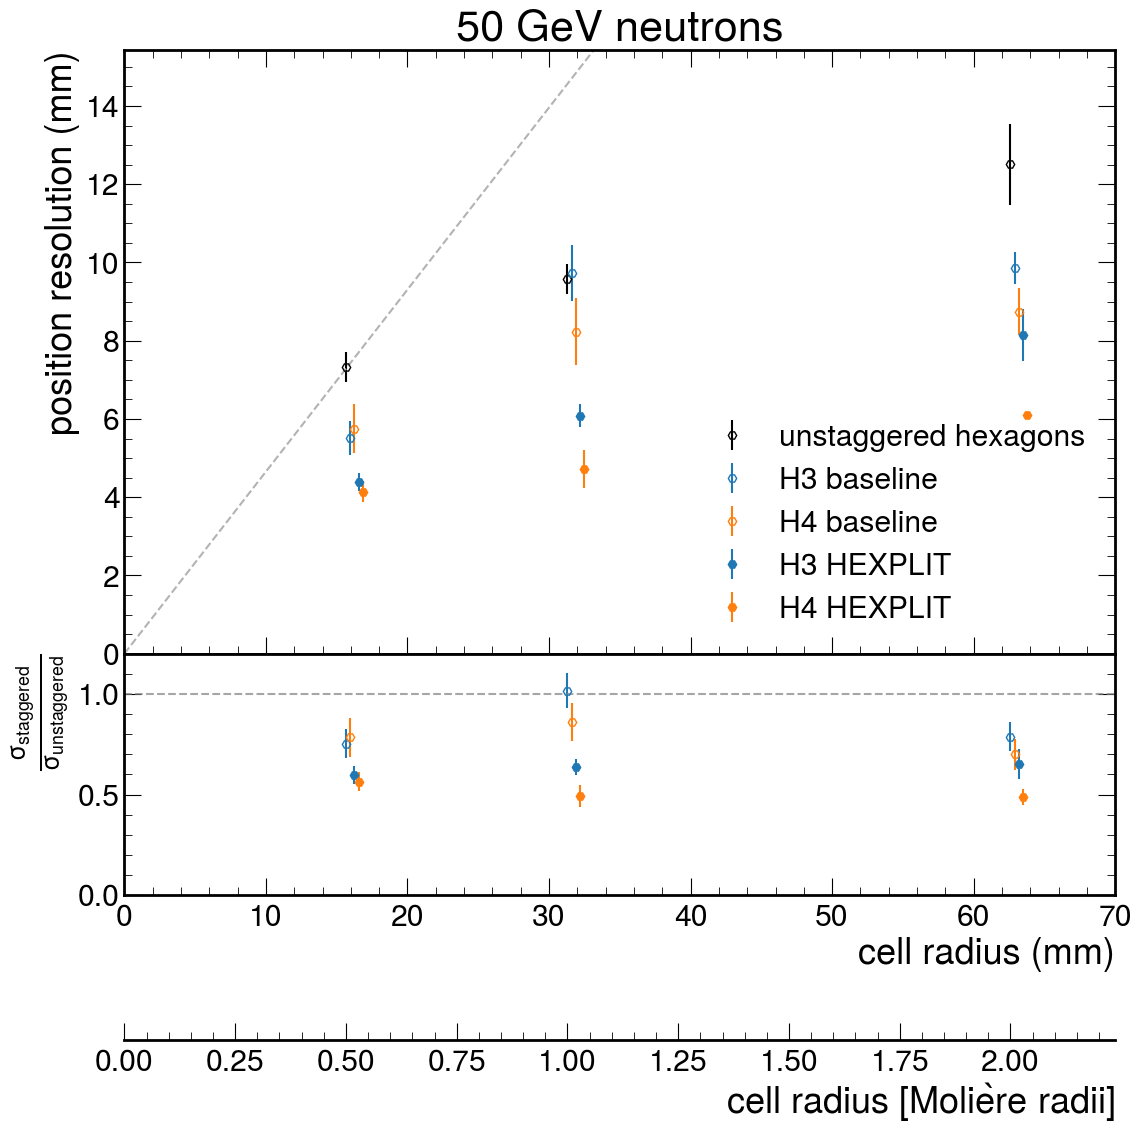

In [121]:
colors=['k', "tab:blue", 'tab:orange', "tab:blue", 'tab:orange']
fillstyles=['none', 'none', 'none', 'full', 'full']
keys=['H1', "H3_baseline", "H4_baseline", "H3_hexplit", "H4_hexplit"]
labels=['unstaggered hexagons',  "H3 baseline", "H4 baseline", "H3 HEXPLIT", "H4 HEXPLIT"]

size_tags="small", "normal", "large"

for j,particle in enumerate(("gamma", "neutron")):
    a=0.4
    fig, axs= plt.subplots(2,1, gridspec_kw=dict(height_ratios=(1,a)),sharex='all', figsize=(12, 8.5*(1+a)))
#     fig, axs=plt.subplots(2,1, figsize=(8,8), sharey='none', sharex='all', 
#                       gridspec_kw=dict(height_ratios=[8, 2]))
    plt.sca(axs[0])
    shift=0.3
    for i in range(5):
        x=np.array([sizes[a]+i*shift for a in size_tags if (particle, a) in res_all])
        
        y=np.array([abs(res_all[(particle,a)][keys[i]]) for a in size_tags if (particle, a) in res_all])
        dy=np.array([dres_all[(particle,a)][keys[i]] for a in size_tags if (particle, a) in res_all])
        plt.errorbar(x,y,dy, color=colors[i], fillstyle=fillstyles[i], label=labels[i], marker='H', ls='')
        
        if i !=0:
            y0=np.array([abs(res_all[(particle,a)][keys[0]]) for a in size_tags if (particle, a) in res_all])
            dy0=np.array([dres_all[(particle,a)][keys[0]] for a in size_tags if (particle, a) in res_all])
            axs[1].errorbar(x-shift,y/y0, y/y0*np.hypot(dy/y,dy0/y0), 
                        color=colors[i], fillstyle=fillstyles[i], label=labels[i], marker='H', ls='')
    
    
    plt.ylabel("position resolution (mm)")
    
    plt.ylim(0, axs[0].get_ylim()[1]*1.1)
    plt.xlim(0, 70)
    
    
    
    ax2 = axs[1].twiny()

    

    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")

    # Offset the twin axis below the host
    ax2.spines["bottom"].set_position(("axes", -0.6))

    # Turn on the frame for the twin axis, but then hide all 
    # but the bottom spine
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    for sp in ax2.spines.values():
        sp.set_visible(False)
    ax2.spines["bottom"].set_visible(True)

    ax2.set_xlabel("cell radius [Moli$\grave{e}$re radii]")
    ax2.set_xlim(ax.get_xlim()[0]/31.3, ax.get_xlim()[1]/31.3)
    
    axs[0].legend()
    if j == 0:
        axs[0].set_title("50 GeV photons")
    else:
        axs[0].set_title("50 GeV neutrons")
    axs[1].set_xlabel("cell radius (mm)")

    axs[1].set_ylabel("$\\frac{\\sigma_{\\rm staggered}}{\\sigma_{\\rm unstaggered}}$")
    
    if False:
        ax2=axs[0].twinx()
        ax2.set_ylim(0, axs[0].get_ylim()[1]/37.5)
        ax2.set_ylabel("$\\theta$ resolution [mrad]")
    axs[1].set_ylim(0, 1.2)
    axs[1].axhline(1, color='0.5', alpha=0.7, ls='--')

    if particle=='neutron':
        axs[0].plot((0, 70), (0, 70*np.sqrt(3*np.sqrt(3)/2)/np.sqrt(12)), color='0.7', ls='--')
    
    #plt.yscale('log')
    plt.tight_layout()
    # Add some extra space for the second axis at the bottom
    fig.subplots_adjust(hspace=0)
    plt.savefig(f"images/cellsize_{particle}.pdf")
    plt.show()

In [117]:
# def shift_recon(df, val):
#     for field in df.columns:
#         if "dr_w0" in field:
#             w0=field.split("_")[-1]
#             df[field] = df.eval(f"sqrt((dx_w0_{w0}+x_truth_w0_{w0}+{val})**2+(dy_w0_{w0}+y_truth_w0_{w0}+{val})**2)"+\
#                                 f"-sqrt((x_truth_w0_{w0})**2+(y_truth_w0_{w0})**2)")
#         elif "dr_rw_w0" in field:
#             w0=field.split("_")[-1]
#             df[field] = df.eval(f"sqrt((dx_rw_w0_{w0}+x_truth_w0_{w0}+{val})**2+(dy_rw_w0_{w0}+y_truth_w0_{w0}+{val})**2)"+\
#                                 f"-sqrt((x_truth_w0_{w0})**2+(y_truth_w0_{w0})**2)")   
            

dr
fit: $\sigma=10.7\pm0.4$ mm
dr
fit: $\sigma=10.3\pm0.4$ mm
dr_rw
fit: $\sigma=-5.5\pm0.3$ mm


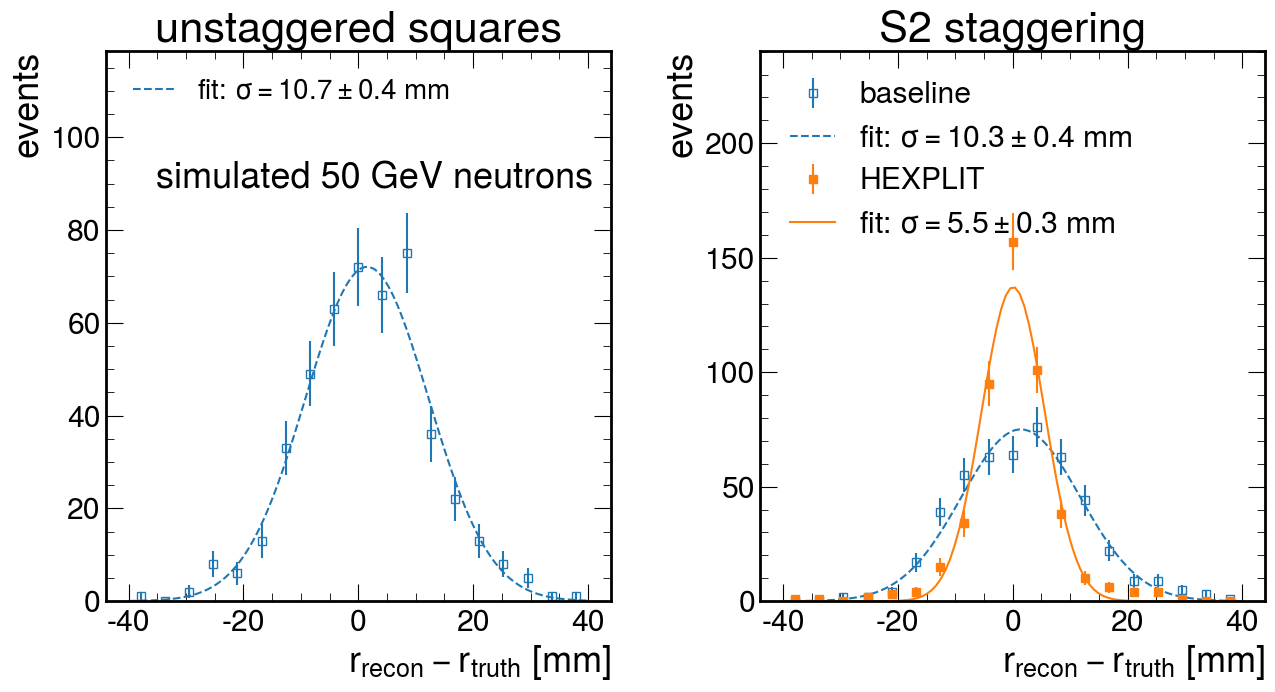

In [118]:

def plots_1d_square(Ebeam, bins=np.linspace(-80, 80, 25)):
    field_nrw='dr'
    field_rw='dr_rw'
    fig,axs=plt.subplots(1,2, figsize=(20*2/3,7.5))
    q="abs(x_truth)<2500 and abs(y_truth)<2500"
    plt.sca(axs[0])
    plt.title("unstaggered squares")
    
    #path=f'dd4hep/zdc_s1_inf_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.root.csv'
    path="../hexplit/unstaggered_squares_recon.csv"
    df = pd.read_csv(path)
    df =df.query(q)
    
    #field=w0_scan(df, field_nrw, bins, **arg_w0)
    field="dr"
    print(field)
    res,dres, eb, curve= res_plot(df[field], bins=bins, 
                                  label=None,eb_args=dict(color='tab:blue', fillstyle='none', marker='s'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'))
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")


    plt.sca(axs[1])
    plt.title("S2 staggering")
    path=f'dd4hep/zdc_s2_inf_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.root.csv'
    path="../hexplit/s2_recon.csv"
    #path=f'dd4hep/zdc_s2_inf_reco_neutron_{Ebeam}GeV_theta_deg.edm4hep.root.csv'
    df = pd.read_csv(path)
    #shift_recon(df, 31.3*np.sqrt(3*np.sqrt(3)/2)*.25)
    #print(df.columns)
    df=df.query(q)
    
    #field=w0_scan(df, field_nrw, bins, **arg_w0)
    field="dr"
    print(field)
    res,dres, eb1, curve1= res_plot(df[field], bins=bins, 
                                  label="baseline", legend=False,eb_args=dict(color='tab:blue', fillstyle='none',
                                                                                   marker='s'),
                                   fitcurve_args=dict(color='tab:blue', linestyle='--'))
    #field=w0_scan(df, field_rw, bins, **arg_w0)
    field="dr_rw"
    print(field)
    res,dres, eb2, curve2= res_plot(df[field], bins=bins, 
                                   label="HEXPLIT", legend=False, eb_args=dict(color='tab:orange', fillstyle='full', 
                                                                                 marker='s'),
                                    fitcurve_args=dict(color='tab:orange', linestyle='-'))
    
    plt.legend(handles=[eb1, curve1[0], eb2, curve2[0]], loc='upper left')
    #plt.legend(handles=[eb1, curve1[0]], loc='upper left')
    plt.xlabel("$r_{\\rm recon}-r_{\\rm truth}$ [mm]")
    
    
    axs[0].text(0.1, 0.75, f"simulated {Ebeam} GeV neutrons", transform=axs[0].transAxes)

    for ax in axs:
        ax.set_ylabel("events")
        ax.set_ylim(0, ax.get_ylim()[1]*1.35)


    plt.tight_layout()
    plt.savefig(f"images/zdc_results_1d_{Ebeam}_GeV_squares.pdf")
    plt.show()
plots_1d_square(50, bins=np.linspace(-40,40, 20))

In [29]:


w0s_used={}
pos_res={}
dpos_res={}
Ebeams={}

for particle in "neutron", "gamma":
    w0s_used[particle]=[[] for i in range(5)]
    pos_res[particle]=[[] for i in range(5)]
    dpos_res[particle]=[[]for i in range(5)]
    Ebeams[particle]=[[]for i in range(5)]

    energies=10, 20, 50, 100, 200, 275

    q="abs(x_truth_w0_4pt0)<250 and abs(y_truth_w0_4pt0)<250"

    windows={"neutron":[55,40,35,30, 16,12],"gamma":[10,10,10,6, 6,5]}
    for i in range(len(energies)):
        E=energies[i]
        bins=np.linspace(-windows[particle][i], windows[particle][i], 20)
        for j, (geo, field,key) in enumerate([("unstaggered","dr", "H1"), 
                                        ("staggered_h3", "dr", "H3_nrw"),
                                        ("staggered_h4", "dr", "H4_nrw"),
                                        ("staggered_h3", "dr_rw", "H3_rw"),
                                        ("staggered_h4", "dr_rw", "H4_rw")]):
            path=f'dd4hep/with_cuts/zdc_{geo}_inf_reco_{particle}_{E}GeV_theta_deg.edm4hep.root.csv'
            #if len(glob.glob(path)) == 0:
            #    path=f'dd4hep/zdc_{geo}_reco_neutron_{E}GeV_theta_deg.edm4hep.root.csv'
            if len(glob.glob(path)) != 0:
                df = pd.read_csv(path)
                df=df.query(q)
                #field=w0_scan(df, field, bins=bins, min_w0=3.5)
                w0 = w0_params[key][0]+np.log(E)*w0_params[key][1] if particle == "neutron" \
                            else w0_params_photon[key][0]+np.log(E)*w0_params_photon[key][1]
                w0=np.round(w0*4)/4
                field=field+f"_w0_{w0}".replace(".", "pt")
                w0s_used[particle][j].append(float(field.split("_")[-1].replace("pt", ".")))
                s, ds= res_calc(df[field], fnc=gauss, bins=bins)
                Ebeams[particle][j].append(E)
                pos_res[particle][j].append(s)
                dpos_res[particle][j].append(ds)
            else:
                #add dummy values to avoid crashing
                Ebeams[particle][j].append(E)
                pos_res[particle][j].append(-1)
                dpos_res[particle][j].append(-1)
    Ebeams[particle] = [np.array(e) for e in Ebeams[particle]]
    pos_res[particle] = [np.array(e) for e in pos_res[particle]]
    dpos_res[particle]= [np.array(e) for e in dpos_res[particle]]
print(dpos_res)

{'neutron': [array([0.88818516, 0.85938073, 0.44128827, 0.34121707, 0.34614878,
       0.25083867]), array([1.06632109, 0.83481887, 0.80374348, 0.34464172, 0.23954121,
       0.09975011]), array([1.35351444, 0.79338953, 0.89111024, 0.38718228, 0.14548202,
       0.07997732]), array([0.78121303, 0.68111774, 0.29032065, 0.33240141, 0.07965907,
       0.0944879 ]), array([1.1489586 , 0.63439312, 0.46902666, 0.16077084, 0.09999744,
       0.0460025 ])], 'gamma': [array([0.31058097, 0.18339528, 0.14409565, 0.1370723 , 0.06140837,
       0.08965908]), array([0.1409001 , 0.07581482, 0.10547061, 0.08094832, 0.07278454,
       0.03863848]), array([0.09496289, 0.10516156, 0.02919767, 0.0502679 , 0.04800604,
       0.07829336]), array([0.15888121, 0.11645129, 0.10949219, 0.10575811, 0.01994072,
       0.04880499]), array([0.05916405, 0.12804786, 0.04197913, 0.02778376, 0.0461292 ,
       0.03357492])]}


[ 10.  20.  50. 100. 200. 275.] [22.53004031 15.18399837  9.67351085  7.53984838  4.80044678  4.47646954]
[ 10.2  20.4  51.  102.  204.  280.5] [20.09567404 14.46809153 10.20094382  6.59405249  4.2054909   3.55343857]
[ 10.4  20.8  52.  104.  208.  286. ] [21.43230889 12.62120703  8.27604946  4.607697    2.57896122  1.97458635]
[ 10.6  21.2  53.  106.  212.  291.5] [14.79478491  9.86541158  6.12918384  4.13543299  2.60042523  2.40292127]
[ 10.8  21.6  54.  108.  216.  297. ] [17.66221365 11.01750348  4.6486408   2.81715045  2.04146006  1.62727573]


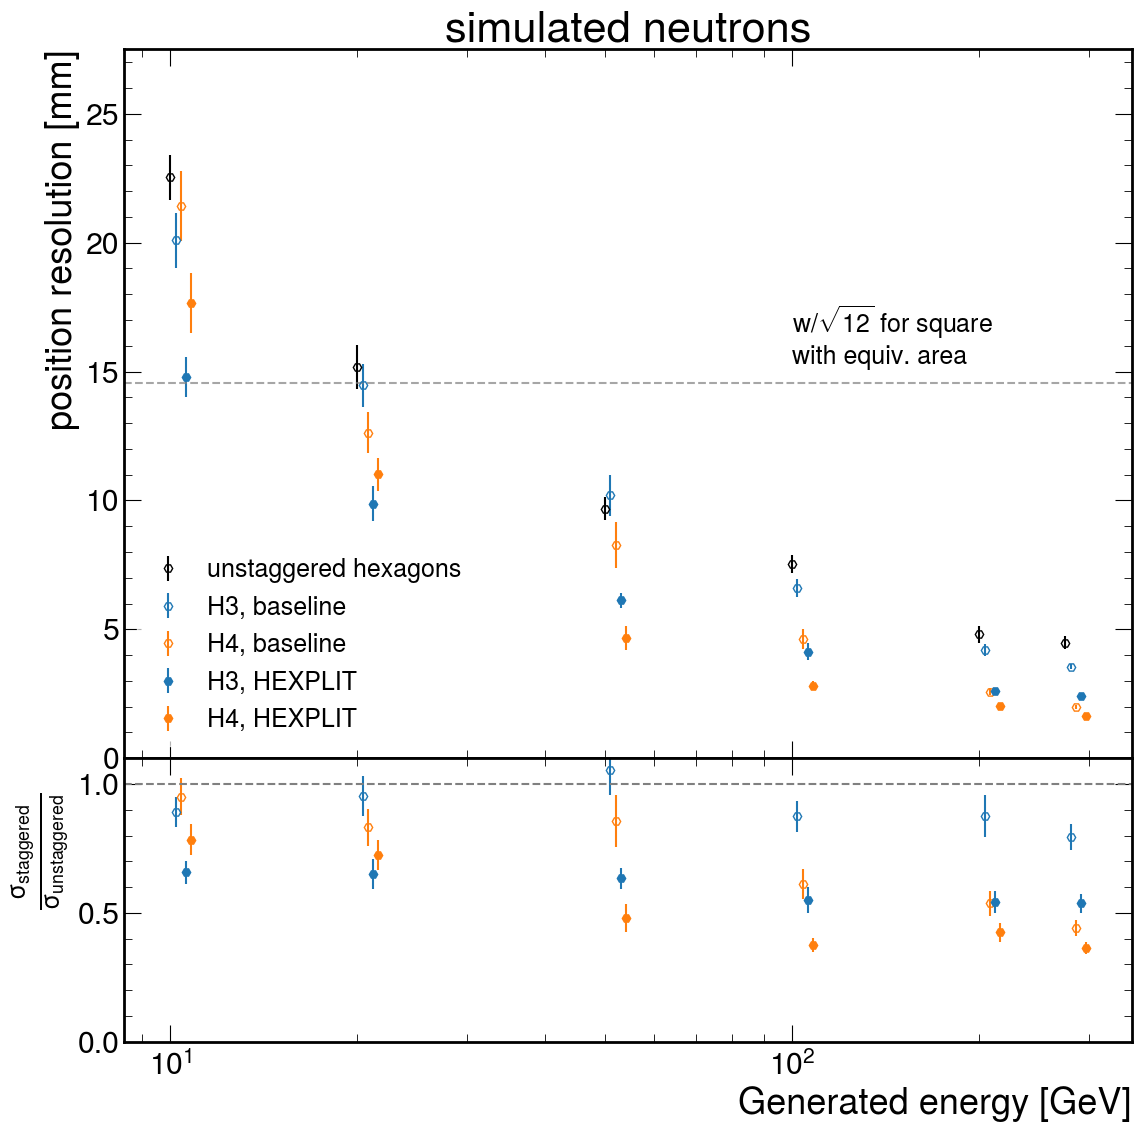

[ 10.  20.  50. 100. 200. 275.] [3.86690512 3.53157049 2.37844285 1.94794197 1.50984667 1.33483804]
[ 10.2  20.4  51.  102.  204.  280.5] [2.93103645 2.54755624 1.91542787 1.42689089 0.86763586 0.87820815]
[ 10.4  20.8  52.  104.  208.  286. ] [2.03773498 1.65971302 1.2718182  0.84704533 0.7453908  0.75381607]
[ 10.6  21.2  53.  106.  212.  291.5] [2.85647382 2.40727703 2.15181885 1.52641581 1.12208979 0.89690755]
[ 10.8  21.6  54.  108.  216.  297. ] [2.25570464 1.94558236 1.44478643 1.07873284 0.84585409 0.64283851]


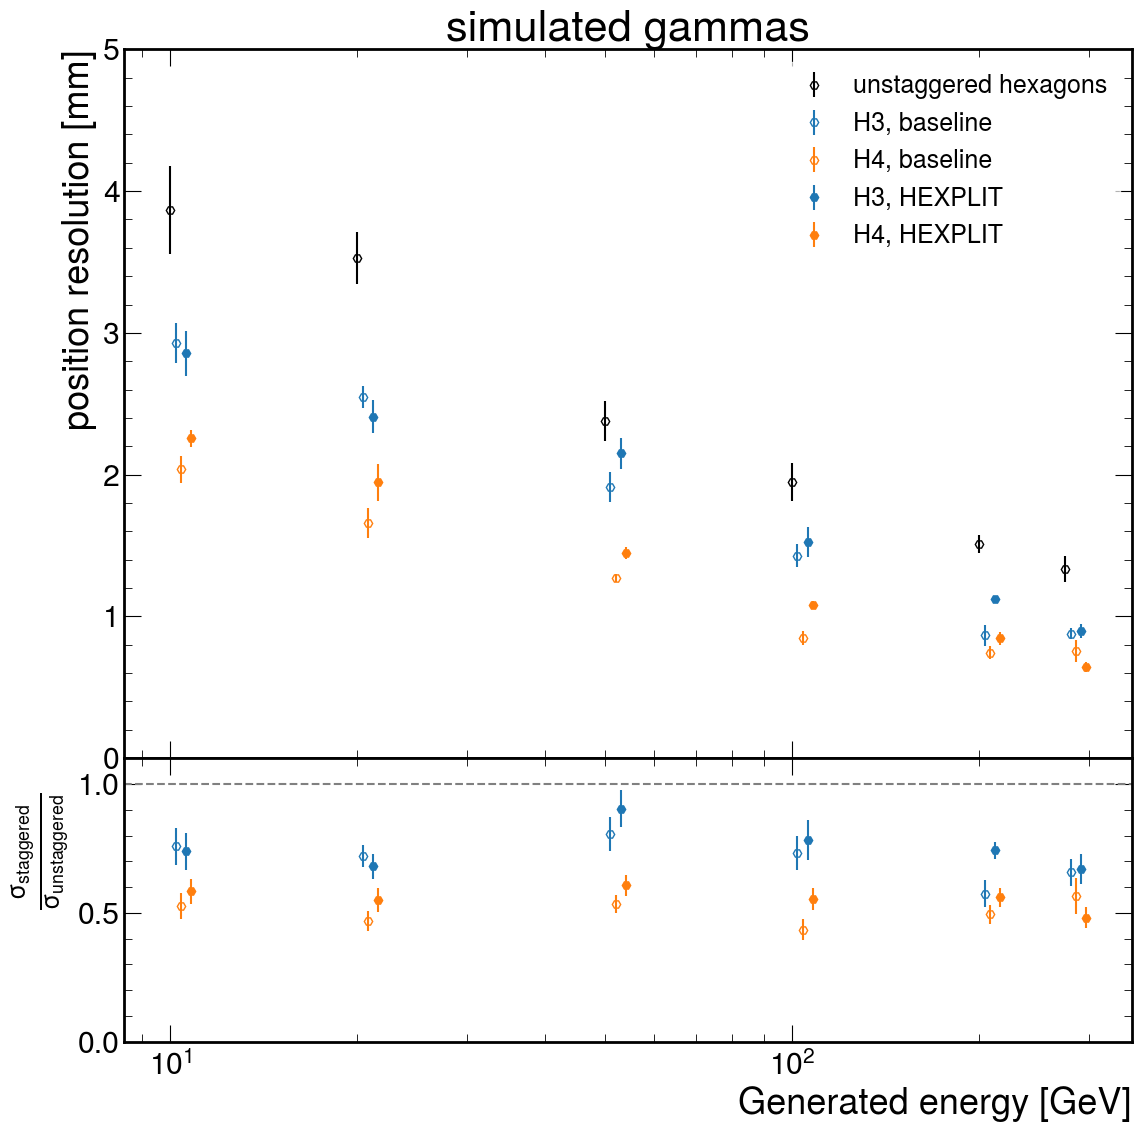

In [23]:
for particle in "neutron", "gamma":
    forZDCPaper=False
    z_in_meters=37.5


    labels="unstaggered hexagons", "H3, baseline", "H4, baseline", "H3, HEXPLIT", "H4, HEXPLIT",
    #pos_res=[r_res_vals_h1, r_res_vals_h3_no_rw, r_res_vals_h4_no_rw, r_res_vals_h3]
    #dpos_res=[r_res_errs_h1, r_res_errs_h3_no_rw, r_res_errs_h4_no_rw, r_res_errs_h3]
    #pos_res=[r_res_vals_h1, r_res_vals_h3_no_rw, None, r_res_vals_h3_rw]
    #dpos_res=[r_res_errs_h1, r_res_errs_h3_no_rw, None, r_res_errs_h3_rw]
    #Ebeams=[[10, 20, 50, 100, 150, 200, 275]]+[[1,2, 5, 10, 20, 30,40,50, 60, 70, 80, 90, 100]]*4

    cols={"H1":"k", "H3": "tab:blue", "H4": "tab:orange"}
    colors=[cols['H1'], cols['H3'], cols['H4'], cols['H3'], cols['H4']]
    fillstyles=['none', 'none', 'none', 'full', 'full']
    markers=['H', 'H', 'H', 'H', 'H']
    a=0.4
    fig, axs= plt.subplots(2,1, gridspec_kw=dict(height_ratios=(1,a)),sharex='all', figsize=(12, 8.5*(1+a)))
    artists=[]
    shift=0.02
    for i in range(5):

        y=pos_res[particle][i]
        dy=np.array(dpos_res[particle][i])
        x=np.array(Ebeams[particle][i])*(1+shift*i)
        print(x,y)
        a=axs[0].errorbar(x, y, dy, marker=markers[i], label=f'{labels[i]}', ls='', fillstyle=fillstyles[i], color=colors[i])
        artists.append(a)
        if i==0:
            y_ref=y
            dy_ref=dy
        else:
            slc=y>0
            axs[1].errorbar(Ebeams[particle][i][slc]*(1+shift*i), (y/y_ref)[slc], (y/y_ref*np.hypot(dy/y, dy_ref/y_ref))[slc], marker=markers[i], ls='', fillstyle=fillstyles[i], color=colors[i])
    

    import matplotlib as mpl, matplotlib.pyplot as plt
    from matplotlib.ticker import MultipleLocator, LogLocator, NullLocator, AutoMinorLocator, NullFormatter


    locminX = LogLocator(base=10.0, subs=np.arange(2, 10) * .1, numticks=100)
    axs[0].set_xscale("log")
    axs[0].xaxis.set_minor_locator(locminX)

    axs[0].set_ylabel("position resolution [mm]")
    axs[1].set_ylabel("$\\frac{\\sigma_{staggered}}{\\sigma_{\\rm unstaggered}}$    ")
    axs[1].set_xlabel("Generated energy [GeV]")

    if particle=="neutron":
        maxy=27.5
        axs[0].set_ylim(0,maxy)
    else:
        axs[0].set_ylim(0,5)

    if forZDCPaper:
        ax2=axs[0].twinx()
        ax2.xaxis.set_minor_locator(locminX)
        ax2.set_ylim(0, maxy/z_in_meters)
        ax2.set_ylabel("$\\theta$ resolution [mrad]")

        a=axs[0].plot(x, 3/np.sqrt(x)*z_in_meters, label="YR requirement: $\\frac{3.0}{\\sqrt{E}}$ mrad", ls='--', color='tab:green')
        artists.append(a[0])

    axs[1].axhline(1,color='0.5', alpha=1, ls='--')

    axs[1].set_ylim(0)
    axs[0].set_xscale('log')

    if particle == "neutron":
        s=31.3
        A=s**2*np.sqrt(3)*3/2
        axs[0].axhline(np.sqrt(A)/np.sqrt(12),color='0.5', alpha=0.7, ls='--')
        axs[0].text(100, 1.05*np.sqrt(A)/np.sqrt(12), "w/$\\sqrt{12}$ for square\nwith equiv. area", fontsize=18,
                   zorder=10)

    #add a dummy artist so that there are 5 entries in a column
    #for i in range(2):
    #    a=axs[0].plot([],[],color='w', label='   ')
    #    artists.append(a[0])

    axs[0].legend(handles=artists,fontsize=18, ncol=1, framealpha=0.7, frameon=True,
                 edgecolor='w', loc='lower left' if particle=="neutron" else "upper right")
    axs[1].set_ylim(0,1.1)
    #maxy=axs[0].get_ylim()[1]
    if forZDCPaper:
        axs[0].set_title("ZDC simulated neutrons")
    else:
        axs[0].set_title(f"simulated {particle}s")
    plt.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.savefig(f"images/position_resolution_{particle}.pdf")
    plt.show()

In [67]:
print(w0s_used)

{'neutron': [[5.5, 5.75, 6.0, 6.25, 6.5, 6.75], [3.75, 4.25, 4.75, 5.0, 5.5, 5.75], [4.0, 4.25, 4.75, 5.0, 5.25, 5.5], [4.25, 4.75, 5.5, 6.0, 6.5, 6.75], [5.0, 5.0, 5.25, 5.5, 5.5, 5.5]], 'gamma': [[6.25, 6.5, 7.0, 7.25, 7.75, 7.75], [5.75, 6.0, 6.25, 6.25, 6.5, 6.75], [5.0, 5.25, 5.75, 6.0, 6.25, 6.5], [6.25, 6.5, 7.0, 7.25, 7.75, 7.75], [5.25, 5.5, 5.5, 5.75, 5.75, 5.75]]}


In [549]:
print(w0s_used)

{'neutron': [[5.5, 5.5, 5.5, 5.5, 5.5, 5.5], [3.75, 3.75, 3.75, 3.75, 3.75, 3.75], [4.0, 4.0, 4.0, 4.0, 4.0, 4.0], [4.25, 4.25, 4.25, 4.25, 4.25, 4.25], [5.0, 5.0, 5.0, 5.0, 5.0, 5.0]], 'gamma': [[5.5, 5.5, 5.5, 5.5, 5.5], [3.75, 3.75, 3.75, 3.75, 3.75], [4.0, 4.0, 4.0, 4.0, 4.0], [4.25, 4.25, 4.25, 4.25, 4.25], [5.0, 5.0, 5.0, 5.0, 5.0]]}


In [331]:
print("$E_n$ [GeV] &unstaggered & H3 (no reweighting) & H4 (no reweighting) & H3 (reweighted) & H4 (reweighted)\\\\\\hline")
energies = 10, 20, 50, 100, 200, 275
for i in range(len(energies)):
    print(str(energies[i]) + " & "+(" & ".join(["%.2f"%w0s_used[j][i] for j in range(5)])) + "\\\\")

$E_n$ [GeV] &unstaggered & H3 (no reweighting) & H4 (no reweighting) & H3 (reweighted) & H4 (reweighted)\\\hline
10 & 3.50 & 3.50 & 5.00 & 3.75 & 4.75\\
20 & 4.25 & 3.50 & 4.50 & 4.75 & 5.50\\
50 & 5.25 & 4.50 & 4.00 & 5.50 & 6.00\\
100 & 6.00 & 4.75 & 4.50 & 5.75 & 6.25\\
200 & 6.25 & 5.25 & 4.75 & 6.25 & 6.50\\
275 & 6.25 & 5.75 & 5.25 & 6.75 & 5.50\\


In [530]:
46.95*2/3

31.3